In [81]:
conda list -e > ../env.yaml


Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import cenpy
import geopandas as gpd
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 999)

/Users/zh3n/opt/miniconda3/envs/final-proj-509/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
# Using NAD83 metre epsg:6564
crs=6564

<AxesSubplot:>

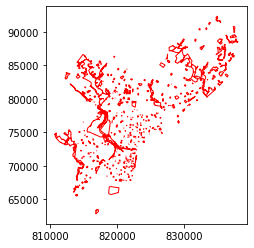

In [4]:
park = gpd.read_file('https://opendata.arcgis.com/datasets/d52445160ab14380a673e5849203eb64_0.geojson')
park = park.to_crs(crs)
parkUnion = gpd.GeoSeries(park.geometry.unary_union)
parkUnion.plot(fc="None", ec="red")


In [5]:
acsVarDict = {
    'B02001_001E': 'Total population',
    'B02001_002E': 'White',
    'B02001_003E': 'Black or African American',
    'B02001_004E': 'American Indian and Alaska Native',
    'B02001_005E': 'Asian',
    'B02001_006E': 'Native Hawaiian and Other Pacific Islander',
    'B06011_001E': 'Median income'}
acsVars = ["NAME"]+list(acsVarDict.keys())

In [6]:
conn = cenpy.remote.APIConnection("ACSDT5Y2019")
acsDataBlockGroup = conn.query(acsVars, geo_unit = 'block group', geo_filter = {"state": "42","county": "101"})
acsDataTract = conn.query(acsVars, geo_unit = 'tract', geo_filter = {"state": "42","county": "101"})

In [7]:
acsData = acsDataTract[["B06011_001E","tract"]].merge(acsDataBlockGroup.drop("B06011_001E",axis=1),how="left",on="tract")


In [8]:
acsData

,B06011_001E,tract,NAME,B02001_001E,B02001_002E,B02001_003E,B02001_004E,B02001_005E,B02001_006E,state,county,block group
0,26636,026000,"Block Group 2, Census Tract 260, Philadelphia ...",800,29,761,0,0,0,42,101,2
1,26636,026000,"Block Group 3, Census Tract 260, Philadelphia ...",1435,82,1219,16,10,0,42,101,3
2,26636,026000,"Block Group 1, Census Tract 260, Philadelphia ...",820,9,786,0,0,0,42,101,1
3,28721,026302,"Block Group 1, Census Tract 263.02, Philadelph...",1319,0,1319,0,0,0,42,101,1
4,28721,026302,"Block Group 2, Census Tract 263.02, Philadelph...",1095,65,1030,0,0,0,42,101,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1331,20520,031401,"Block Group 2, Census Tract 314.01, Philadelph...",1626,487,268,0,313,0,42,101,2
1332,20520,031401,"Block Group 4, Census Tract 314.01, Philadelph...",880,307,95,0,410,0,42,101,4
1333,20346,031402,"Block Group 2, Census Tract 314.02, Philadelph...",1685,520,324,9,596,0,42,101,2
1334,20346,031402,"Block Group 3, Census Tract 314.02, Philadelph...",2904,996,300,8,1031,0,42,101,3


In [9]:
conn.set_mapservice("tigerWMS_ACS2019")

Connection to American Community Survey: 5-Year Estimates: Detailed Tables 5-Year(ID: https://api.census.gov/data/id/ACSDT5Y2019)
With MapServer: Census ACS 2019 WMS

In [10]:
whereClause = "STATE = 42 AND COUNTY = 101"
phillyGeo = conn.mapservice.layers[10].query(where=whereClause)

/Users/zh3n/opt/miniconda3/envs/final-proj-509/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [11]:
acsDataGeo = (phillyGeo
               .merge(acsData,
                  left_on=["STATE", "COUNTY", "TRACT", "BLKGRP"],
                  right_on=["state", "county", "tract", "block group"],)
               .rename(acsVarDict,axis=1)
               .to_crs(crs))

In [12]:
acsColList = ["GEOID",'Total population', 'White', 'Median income',"geometry"]
acsDataGeo = acsDataGeo[acsColList].copy()
acsDataGeo[acsColList[:-1]] = acsDataGeo[acsColList[:-1]].astype("int")

In [13]:
# Dividing Race into White and non-White, because other race like Asian
# has small population.

acsDataGeo["White"] = acsDataGeo["White"] / acsDataGeo["Total population"]
acsDataGeo["Non-White"] = 1 - acsDataGeo["White"] 

In [14]:
acsDataGeo.dtypes

GEOID                  int64
Total population       int64
White                float64
Median income          int64
geometry            geometry
Non-White            float64
dtype: object

In [15]:
# There is some missing data in DF
acsDataGeo = acsDataGeo.fillna(0)

# The income of some tracts is -66666666
acsDataGeo.loc[acsDataGeo["Median income"]<0,'Median income'] = np.nan

<AxesSubplot:>

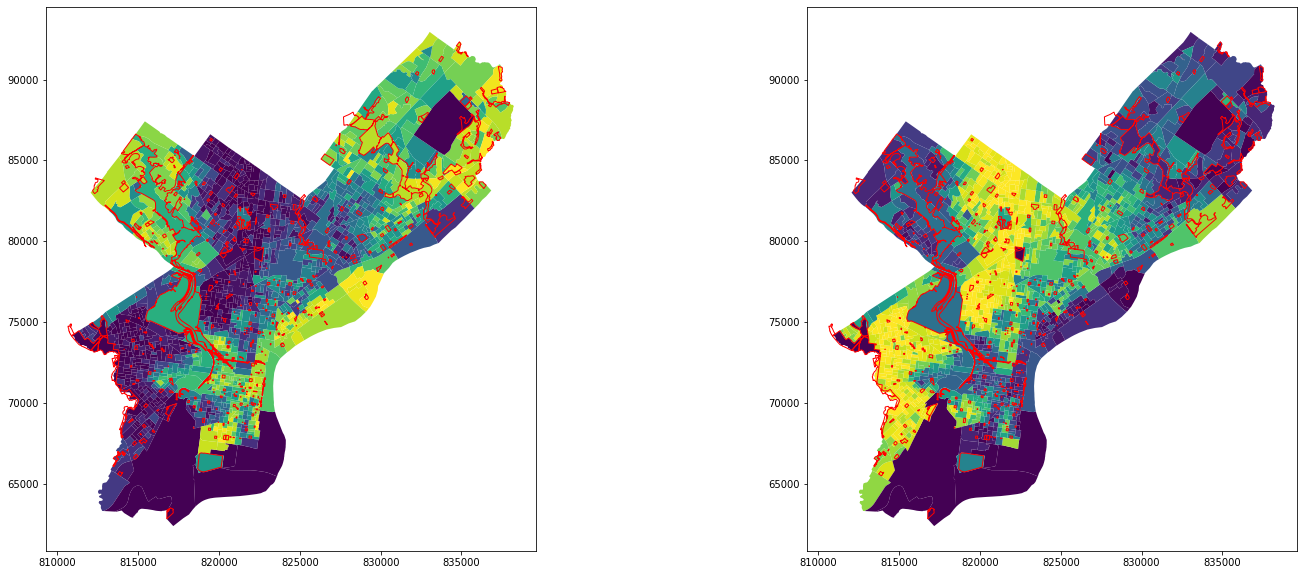

In [16]:
fig,axes = plt.subplots(ncols=2,figsize=(25,10))

acsDataGeo.plot(column="White",ax=axes[0])
acsDataGeo.plot(column="Non-White",ax=axes[1])

parkUnion.plot(fc="None", ec="red",ax=axes[0])
parkUnion.plot(fc="None", ec="red",ax=axes[1])


<AxesSubplot:>

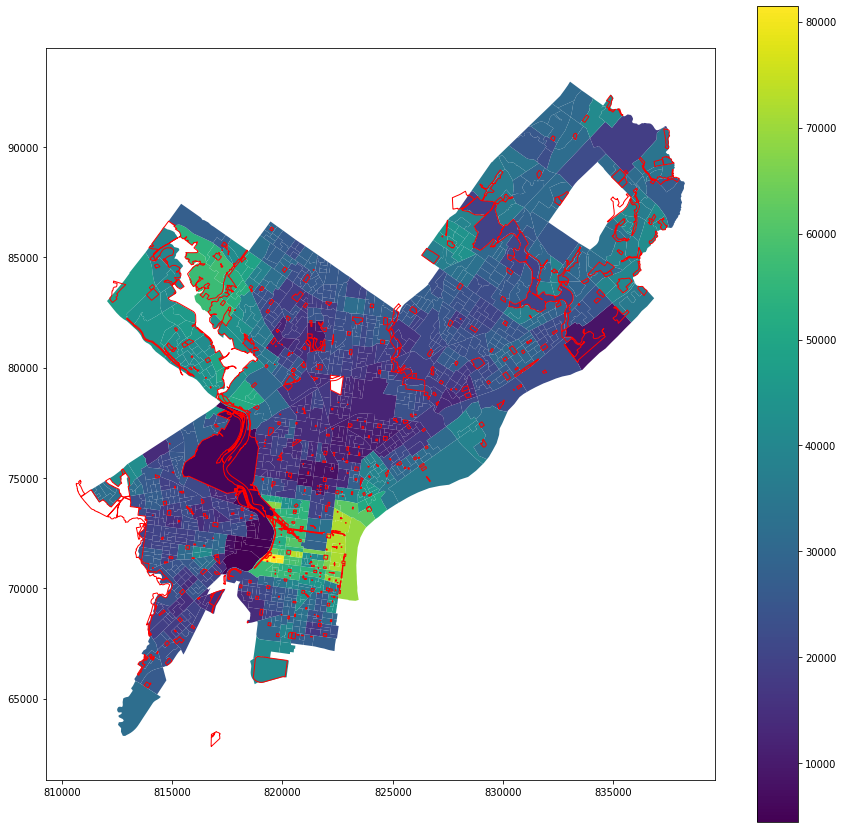

In [17]:
fig,axis = plt.subplots(figsize=(15,15))
acsDataGeo.plot(column="Median income",ax=axis,legend=True)

parkUnion.plot(fc="None", ec="red",ax=axis)

In [18]:
# calculate park area within distance
# at what distance?

# may be not the best method!
# the blockgroups have different sizes
from math import log
searchDistance = 500 # (m)

def getParkAreaWithinDistance(acsblockgroups: gpd.GeoDataFrame, distance: float, park: gpd.GeoDataFrame):
    buffer = acsblockgroups.geometry.buffer(distance)
    area = park.intersection(buffer).area
    return(area.squeeze())

acsDataGeo["parkArea"] = acsDataGeo.apply(getParkAreaWithinDistance, axis=1,
                                          distance=searchDistance, park=parkUnion)
acsDataGeo['logParkArea'] = acsDataGeo.parkArea.add(1).apply(log)




In [19]:
acsDataGeo.parkArea


0           0.000000
1       44767.458926
2       26511.338842
3        8587.681649
4        8587.681649
            ...     
1331    31429.961169
1332    57373.228644
1333    36650.063386
1334    50994.131083
1335    61413.896981
Name: parkArea, Length: 1336, dtype: float64

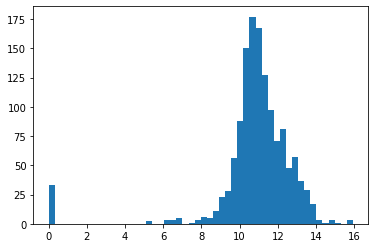

In [20]:
plt.hist(acsDataGeo.parkArea.add(1).apply(log), bins=50)
plt.show()

<AxesSubplot:>

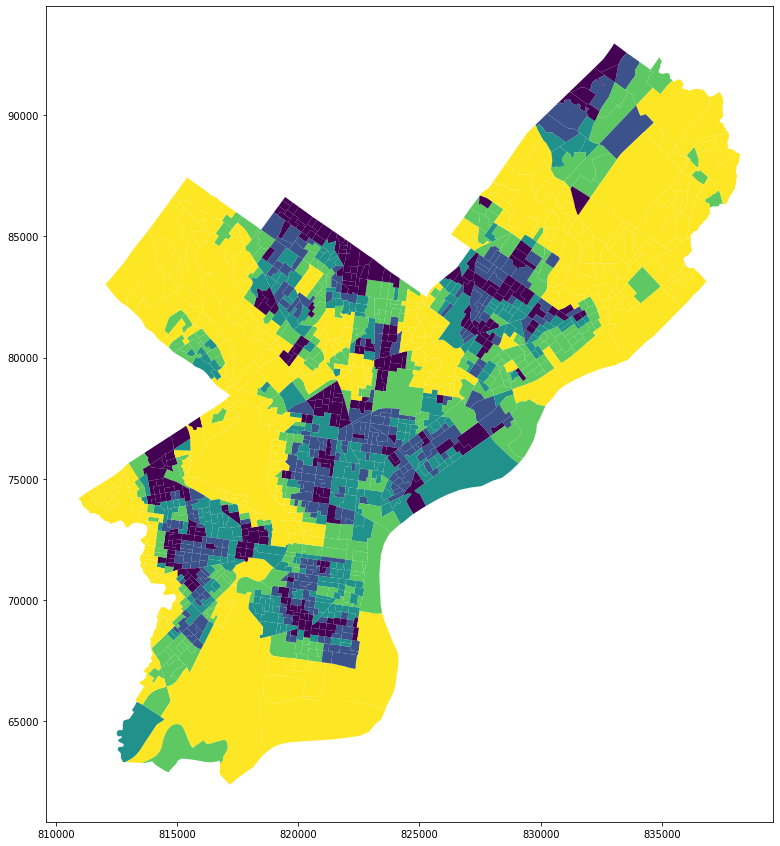

In [23]:
fig,axis = plt.subplots(figsize=(15,15))
acsDataGeo.plot(column="logParkArea",scheme='quantiles',ax=axis)